<a href="https://colab.research.google.com/github/WaithiraHawi/Customer-Journey-Mapping-and-Prediction/blob/main/CustomerJourney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
file_path = "/content/TravelData.csv"
df = pd.read_csv(file_path, on_bad_lines='skip', engine='python')
df = pd.read_csv(file_path)

In [3]:
# Data Preprocessing
df['TIMESPSS'] = pd.to_datetime(df['TIMESPSS'], errors='coerce')

# Create time-based features
df['Date'] = df['TIMESPSS'].dt.date
df['Hour'] = df['TIMESPSS'].dt.hour
df['DayOfWeek'] = df['TIMESPSS'].dt.day_name()
df['Month'] = df['TIMESPSS'].dt.month_name()

In [4]:
# Summary Statistics
summary_stats = {
    "Total Unique Users": df['UserID'].nunique(),
    "Total Purchases": df['PurchaseID'].nunique(),
    "Total Interactions": len(df),
    "Avg Session Duration (min)": df['Duration'].mean(),
    "Device Usage": df['DEVICE_TYPE'].value_counts(normalize=True) * 100,
    "Purchase Own Rate (%)": (df['purchase_own'].sum() / len(df)) * 100,
    "Purchase Any Rate (%)": (df['purchase_any'].sum() / len(df)) * 100
}

print("=== Summary Statistics ===")
for key, value in summary_stats.items():
    print(f"{key}: \n{value}\n")

=== Summary Statistics ===
Total Unique Users: 
9678

Total Purchases: 
29012

Total Interactions: 
2456414

Avg Session Duration (min): 
56.02421890695526

Device Usage: 
DEVICE_TYPE
FIXED     80.835682
MOBILE    19.164318
Name: proportion, dtype: float64

Purchase Own Rate (%): 
3.3016828596482513

Purchase Any Rate (%): 
34.57678550928304



/tmp/ipython-input-3793712929.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='DEVICE_TYPE', palette='coolwarm')


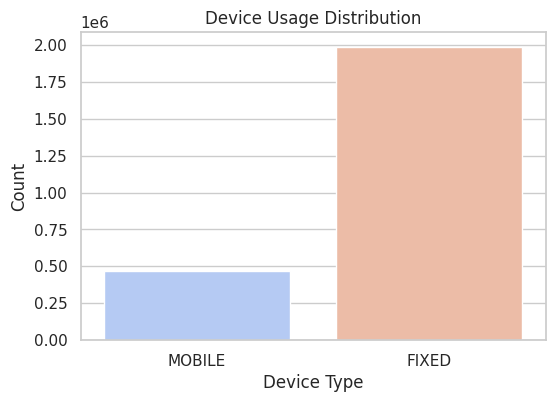

/tmp/ipython-input-3793712929.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='DayOfWeek', order=order_days, palette='viridis')


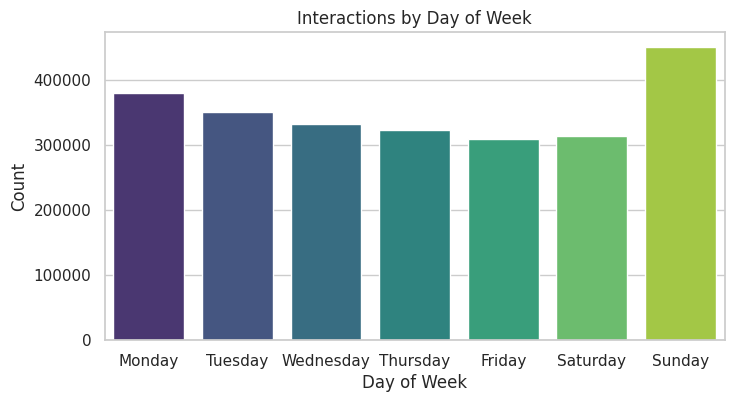

/tmp/ipython-input-3793712929.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=purchase_rate_by_device, x='DEVICE_TYPE', y='purchase_any', palette='mako')


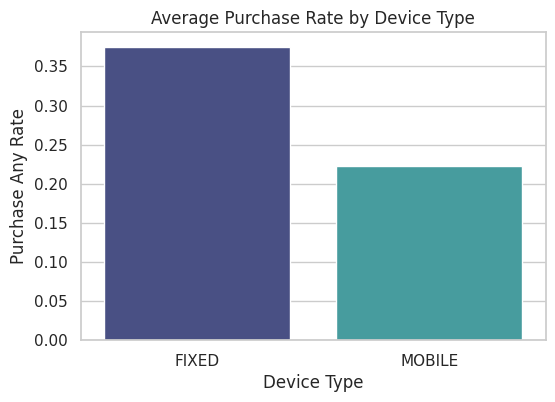

In [5]:
# Visualizations
sns.set(style="whitegrid")

# Device usage distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='DEVICE_TYPE', palette='coolwarm')
plt.title('Device Usage Distribution')
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.show()

# Interactions by Day of Week
plt.figure(figsize=(8,4))
order_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.countplot(data=df, x='DayOfWeek', order=order_days, palette='viridis')
plt.title('Interactions by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.show()

# Purchase rate by device type
purchase_rate_by_device = df.groupby('DEVICE_TYPE')[['purchase_any']].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=purchase_rate_by_device, x='DEVICE_TYPE', y='purchase_any', palette='mako')
plt.title('Average Purchase Rate by Device Type')
plt.ylabel('Purchase Any Rate')
plt.xlabel('Device Type')
plt.show()

/tmp/ipython-input-3129275200.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=funnel, x='Stage', y='ConversionRate', palette='plasma')


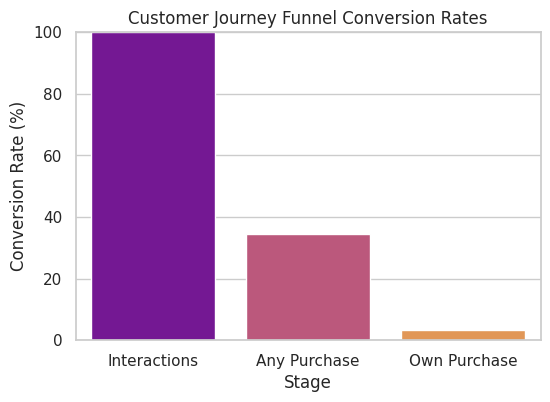

In [6]:
# Funnel Analysis
funnel = pd.DataFrame({
    "Stage": ["Interactions", "Any Purchase", "Own Purchase"],
    "Count": [len(df), df['purchase_any'].sum(), df['purchase_own'].sum()]
})
funnel['ConversionRate'] = (funnel['Count'] / funnel['Count'].iloc[0]) * 100

plt.figure(figsize=(6,4))
sns.barplot(data=funnel, x='Stage', y='ConversionRate', palette='plasma')
plt.title('Customer Journey Funnel Conversion Rates')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Stage')
plt.ylim(0, 100)
plt.show()

In [7]:
# Cohort & Retention Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Assumes df is already loaded and 'TIMESPSS' is datetime
# If running standalone, uncomment these two lines and change path:
# file_path = "TravelData.csv"
# df = pd.read_csv(file_path); df['TIMESPSS'] = pd.to_datetime(df['TIMESPSS'], errors='coerce')

# Creating Period column (month period when the interaction happened)
df = df.copy()
df['EventMonth'] = df['TIMESPSS'].dt.to_period('M').dt.to_timestamp()  # first day of month

In [8]:
# Determining each user's cohort (first event month)
user_first_event = df.groupby('UserID')['TIMESPSS'].min().dt.to_period('M').dt.to_timestamp()
user_first_event.name = 'CohortMonth'

# Merging cohort month back to the main df
df = df.merge(user_first_event, left_on='UserID', right_index=True, how='left')

In [9]:
# Calculating CohortIndex (1 = first month, 2 = second month after first interaction, etc.)
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + (d1.month - d2.month) + 1

df['CohortIndex'] = df.apply(lambda row: diff_month(row['EventMonth'], row['CohortMonth']), axis=1)

In [10]:
# Building cohort counts: number of unique users in each cohort (size) and active users per cohort index
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['UserID'].nunique().reset_index()
cohort_sizes = cohort_data[cohort_data['CohortIndex'] == 1][['CohortMonth', 'UserID']].set_index('CohortMonth')
cohort_sizes.columns = ['CohortSize']

# Merging cohort sizes into cohort_data
cohort_data = cohort_data.join(cohort_sizes, on='CohortMonth')
cohort_data['RetentionRate'] = cohort_data['UserID'] / cohort_data['CohortSize']

In [11]:
# Pivoting to create retention matrix (rows: cohort month, cols: cohort index)
retention_matrix = cohort_data.pivot_table(index='CohortMonth',
                                           columns='CohortIndex',
                                           values='RetentionRate',
                                           aggfunc='first').fillna(0)

# Save retention matrix to CSV
retention_matrix.to_csv('retention_matrix.csv')

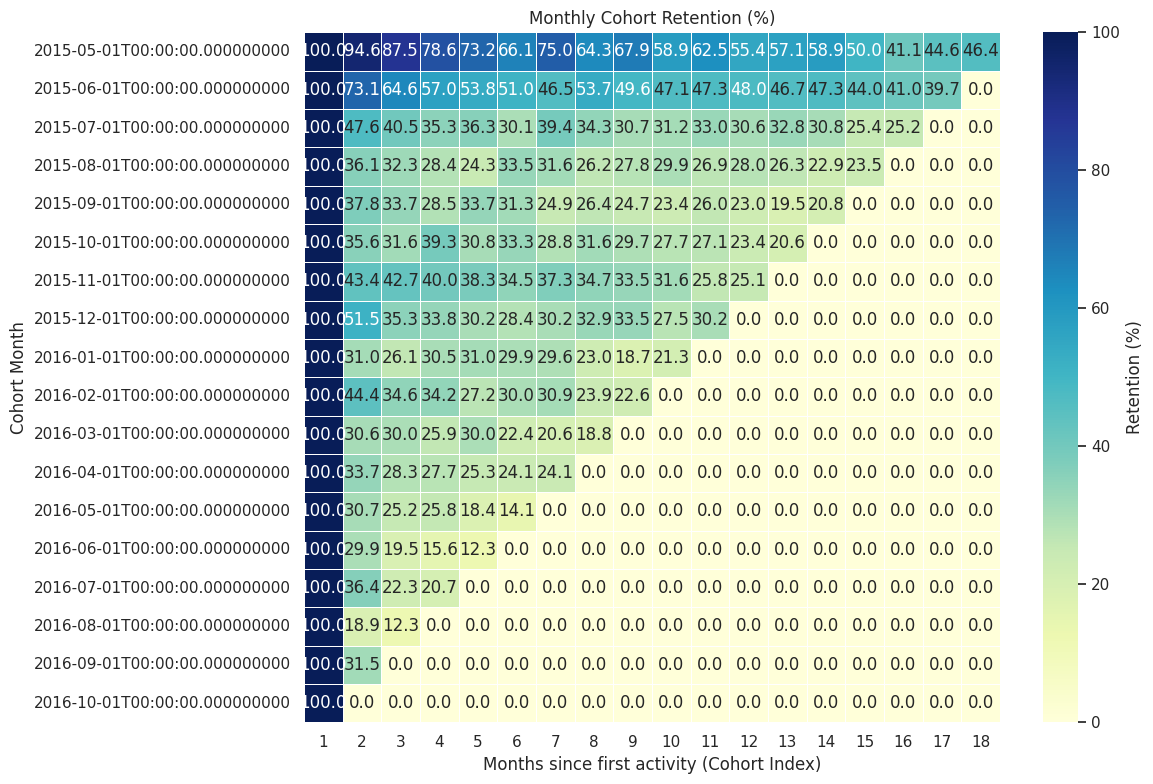

In [12]:
# Plot retention heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix * 100,                # show percentages
            annot=True, fmt=".1f", linewidths=.5,
            cmap='YlGnBu', cbar_kws={'label': 'Retention (%)'})
plt.title('Monthly Cohort Retention (%)')
plt.ylabel('Cohort Month')
plt.xlabel('Months since first activity (Cohort Index)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('cohort_retention_heatmap.png', dpi=150)
plt.show()

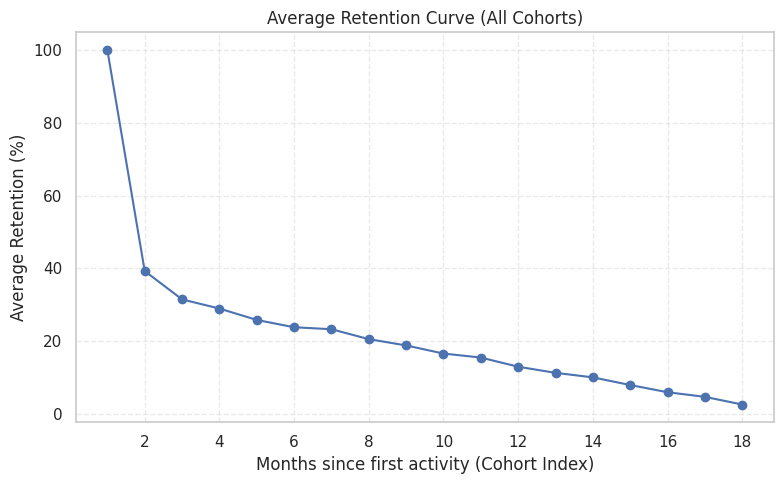

In [13]:
# Cohort retention curves (average retention across cohorts by month index)
avg_retention_by_index = retention_matrix.mean(axis=0)  # average retention for each cohort index
plt.figure(figsize=(8,5))
plt.plot(avg_retention_by_index.index, avg_retention_by_index.values * 100, marker='o')
plt.title('Average Retention Curve (All Cohorts)')
plt.xlabel('Months since first activity (Cohort Index)')
plt.ylabel('Average Retention (%)')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('avg_retention_curve.png', dpi=150)
plt.show()

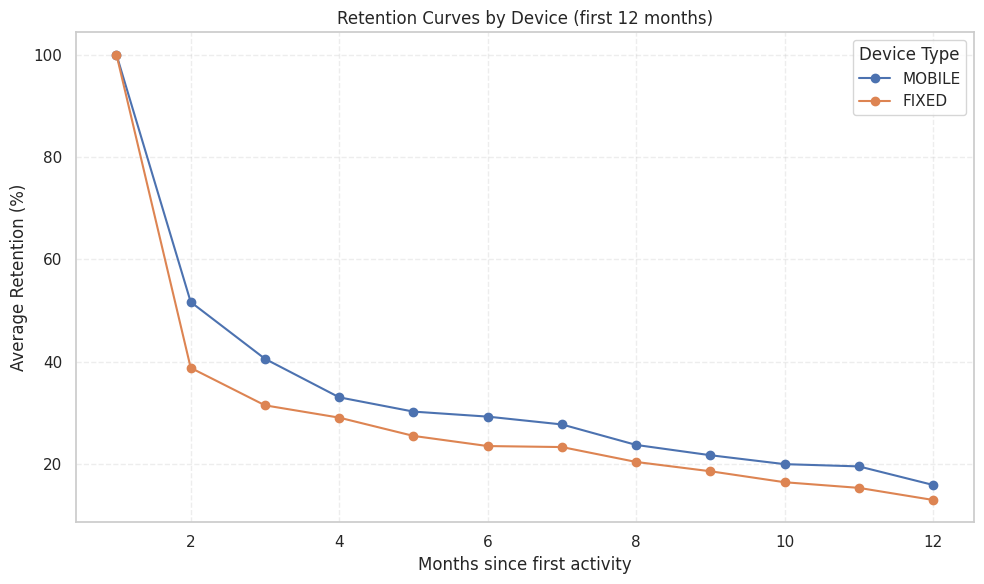

In [14]:
# Cohort analysis by DEVICE_TYPE (example: FIXED vs MOBILE)
device_retentions = {}
for device in df['DEVICE_TYPE'].dropna().unique():
    ddf = df[df['DEVICE_TYPE'] == device]
    # cohort sizes for this device: count unique users whose first event (CohortMonth) is X AND device appears in that user's events
    # Simpler approach: compute active users per cohort month & index filtered to device
    d_cohort = ddf.groupby(['CohortMonth', 'CohortIndex'])['UserID'].nunique().reset_index()
    d_cohort = d_cohort.join(
        d_cohort[d_cohort['CohortIndex'] == 1][['CohortMonth', 'UserID']].set_index('CohortMonth'),
        on='CohortMonth', rsuffix='_CohortSize'
    )
    # If some cohorts have no device-specific first-month users, fallback to global cohort size (so percentages are comparable)
    d_cohort = d_cohort.merge(cohort_sizes, left_on='CohortMonth', right_index=True, how='left')
    # Prefer device-specific cohort size if available else use global cohort size
    d_cohort['DeviceCohortSize'] = d_cohort['UserID_CohortSize'].fillna(d_cohort['CohortSize'])
    d_cohort['RetentionRate'] = d_cohort['UserID'] / d_cohort['DeviceCohortSize']
    d_ret_matrix = d_cohort.pivot_table(index='CohortMonth', columns='CohortIndex', values='RetentionRate', aggfunc='first').fillna(0)
    device_retentions[device] = d_ret_matrix

# Plotting retention curves for each device (first 12 months to keep chart readable)
plt.figure(figsize=(10,6))
for device, mat in device_retentions.items():
    avg = mat.mean(axis=0).loc[1:12]  # restrict to first 12 months
    plt.plot(avg.index, avg.values * 100, marker='o', label=device)

plt.title('Retention Curves by Device (first 12 months)')
plt.xlabel('Months since first activity')
plt.ylabel('Average Retention (%)')
plt.legend(title='Device Type')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True, linestyle='--', alpha=0.35)
plt.tight_layout()
plt.savefig('device_retention_curves.png', dpi=150)
plt.show()

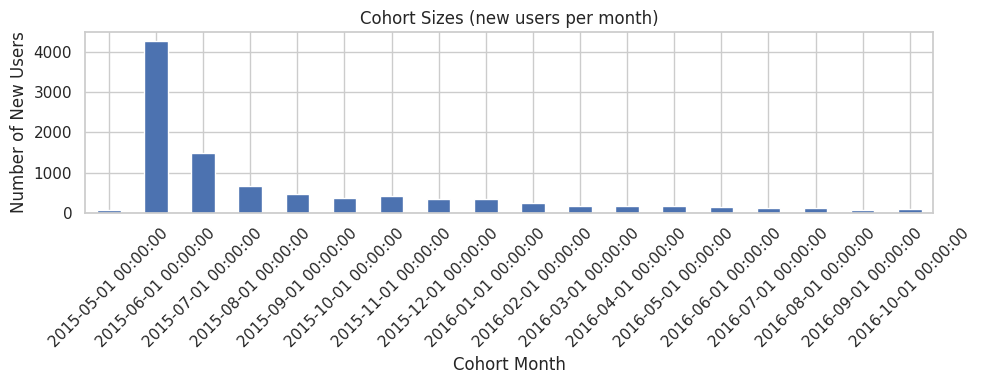

In [15]:
# Cohort size (number of new users per cohort month) - helpful to assess growth
cohort_size_series = cohort_sizes['CohortSize'].sort_index()
plt.figure(figsize=(10,4))
cohort_size_series.plot(kind='bar')
plt.title('Cohort Sizes (new users per month)')
plt.xlabel('Cohort Month')
plt.ylabel('Number of New Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('cohort_sizes.png', dpi=150)
plt.show()

In [16]:
# Saving processed cohort data for inspection
cohort_data.to_csv('cohort_data_long.csv', index=False)

# === Quick interpretation helpers (print top lines) ===
print("Retention matrix (first 6 cohorts):")
print(retention_matrix.head(6).round(3))

print("\nAverage retention by month index (first 12 months):")
print((avg_retention_by_index.loc[1:12] * 100).round(2))

print("\nCohort sizes (latest 6 months):")
print(cohort_size_series.sort_index().tail(6))

Retention matrix (first 6 cohorts):
CohortIndex   1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                
2015-05-01   1.0  0.946  0.875  0.786  0.732  0.661  0.750  0.643  0.679   
2015-06-01   1.0  0.731  0.646  0.570  0.538  0.510  0.465  0.537  0.496   
2015-07-01   1.0  0.476  0.405  0.353  0.363  0.301  0.394  0.343  0.307   
2015-08-01   1.0  0.361  0.323  0.284  0.243  0.335  0.316  0.262  0.278   
2015-09-01   1.0  0.378  0.337  0.285  0.337  0.313  0.249  0.264  0.247   
2015-10-01   1.0  0.356  0.316  0.393  0.308  0.333  0.288  0.316  0.297   

CohortIndex     10     11     12     13     14     15     16     17     18  
CohortMonth                                                                 
2015-05-01   0.589  0.625  0.554  0.571  0.589  0.500  0.411  0.446  0.464  
2015-06-01   0.471  0.473  0.480  0.467  0.473  0.440  0.410  0.397  0.000  
2015-07-01   0.312  0.330  0.306  0.328  0.308 